In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time
from threading import Thread

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=self.capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()

    def capacity(self):
        return self.capacity

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
# PLOT_AVG is the number of episodes to average rewards over
# MAX_STEPS is the maximum number of steps to take in an episode
# EPS_CUTOFF is the number of episodes at max steps to allow before cutting early
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 600
TAU = 0.005
LR = 1e-4
PLOT_AVG = 50
MAX_STEPS = 500
EPS_CUTOFF = 10

In [6]:
def select_actions(envs, policy_net, states, steps_done):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    if sample > eps_threshold:
      with torch.no_grad():
          return policy_net(states).max(1).indices
    else:
        return torch.tensor( envs.action_space.sample() , device=device, dtype=torch.long)

In [7]:
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # # Take 100 episode averages and plot them too
    # if len(durations_t) >= PLOT_AVG:
    #     means = durations_t.unfold(0, PLOT_AVG, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(PLOT_AVG - 1), means))
    #     plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [8]:
def optimize_model(policy_net, target_net, optimizer, memory):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [23]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 100
else:
    num_episodes = 50



def do_step(envs, dones, policy_net, memory, states, steps_done, num_envs, n_observations):
    actions = select_actions(envs, policy_net, states, steps_done)
    steps_done += 1

    observations, rewards, terminateds, truncateds, _ = envs.step(
        actions.cpu().numpy()
    )

    # CUSTOM reward
    # https://gymnasium.farama.org/environments/classic_control/cart_pole/
    rewards = (
        0.105 - abs(observations[:, 2])
    ) / 0.105  # 0 to 1 based on pole angle, closer to 0 = more reward

    rewards = torch.tensor(rewards, device=device)
    dones = np.logical_or(dones, np.logical_or(terminateds, truncateds))

    # for all non-terminated states, set next_state
    next_states = torch.full(
        (num_envs, n_observations), torch.nan, device=device
    )
    obs = torch.tensor(observations, dtype=torch.float32, device=device)
    next_states[~terminateds] = obs[~terminateds]

    # Store the transition in memory
    for e in range(num_envs):
        if not dones[e]:
            memory.push(
                states[e].view(1, n_observations),
                actions[e].view(1, 1),
                (
                    next_states[e].view(1, n_observations)
                    if not dones[e]
                    else None
                ),
                rewards[e].view(1),
            )

    # Move to the next state
    states = next_states

    return actions, dones, states, steps_done


def train(num_envs = 8, display_live = False):
    episode_durations = []
    memory = ReplayMemory(10000)
    steps_done = 0

    envs = gym.make_vec("CartPole-v1", num_envs=num_envs, vectorization_mode="async")

    # Get number of actions from gym action space
    n_actions = envs.single_action_space.n
    # Get the number of state observations
    n_observations = envs.single_observation_space.shape[0]
    
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    
    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

    # # buffer warmup
    # states, infos = envs.reset()
    # states = torch.tensor(
    #     states, dtype=torch.float32, device=device
    # )
    # dones = np.full(num_envs, False)
    # while len(memory) < memory.capacity:
    #     actions, dones, states, steps_done = do_step(
    #         envs, dones, policy_net, memory, states, steps_done, num_envs, n_observations
    #     )
    #     if dones.any():
    #         states, infos = envs.reset()
    #         states = torch.tensor(
    #             states, dtype=torch.float32, device=device
    #         )
    #         dones = np.full(num_envs, False)
    # # while buffer warmup
    # print("Finished filling buffer (%s)" % len(memory))

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        states, infos = envs.reset()
        states = torch.tensor(
            states, dtype=torch.float32, device=device
        )  # .unsqueeze(0)

        dones = np.full(num_envs, False)

        for t in range(MAX_STEPS + 1):

            actions, dones, states, steps_done = do_step(
                envs, dones, policy_net, memory, states, steps_done, num_envs, n_observations
            )

            # Perform one step of the optimization (on the policy network)
            optimize_model(policy_net, target_net, optimizer, memory)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[
                    key
                ] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)

            if dones.all():  # once all are done
                episode_durations.append(t + 1)  # max
                if display_live:
                    plot_durations(episode_durations)
                break
        # for t steps

				# early stop
        # if at MAX_STEPS for last EPS_CUTOFF episodes, break
        if i_episode > EPS_CUTOFF:
            if (
                len(set(episode_durations[-EPS_CUTOFF:])) == 1
                and episode_durations[-1] == MAX_STEPS
            ):
                break
    # for i_episode

    return np.array(episode_durations)

In [10]:
def graphs_compare(*args, labels=None):
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(args))]
    
    num_datasets = len(args)
    num_columns = min(3, num_datasets)
    num_rows = (num_datasets + 2) // 3  # Calculate number of rows needed
    
    # Find global max and min across all datasets
    global_max = max(data.max() for data in args) + 10
    global_min = min(data.min() for data in args)

    global_x_max = max(data.shape[0] for data in args)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(6 * num_columns, 4 * num_rows), squeeze=False)
    
    for i, (data, label) in enumerate(zip(args, labels)):
        ax = axes[i // num_columns, i % num_columns]  # Locate the correct subplot
        ax.plot(data)
        ax.set_title(label)
        ax.set_xlabel('Epochs')
        ax.grid(True)
        ax.set_ylim(global_min, global_max)  # Set the y-axis limit to be the same for all subplots
        ax.set_xlim(0, global_x_max)  # Set the x-axis limit to be the same for all subplots
    
    # Hide unused axes if any
    for j in range(i + 1, num_rows * num_columns):
        axes[j // num_columns, j % num_columns].axis('off')

    plt.tight_layout()
    plt.show()

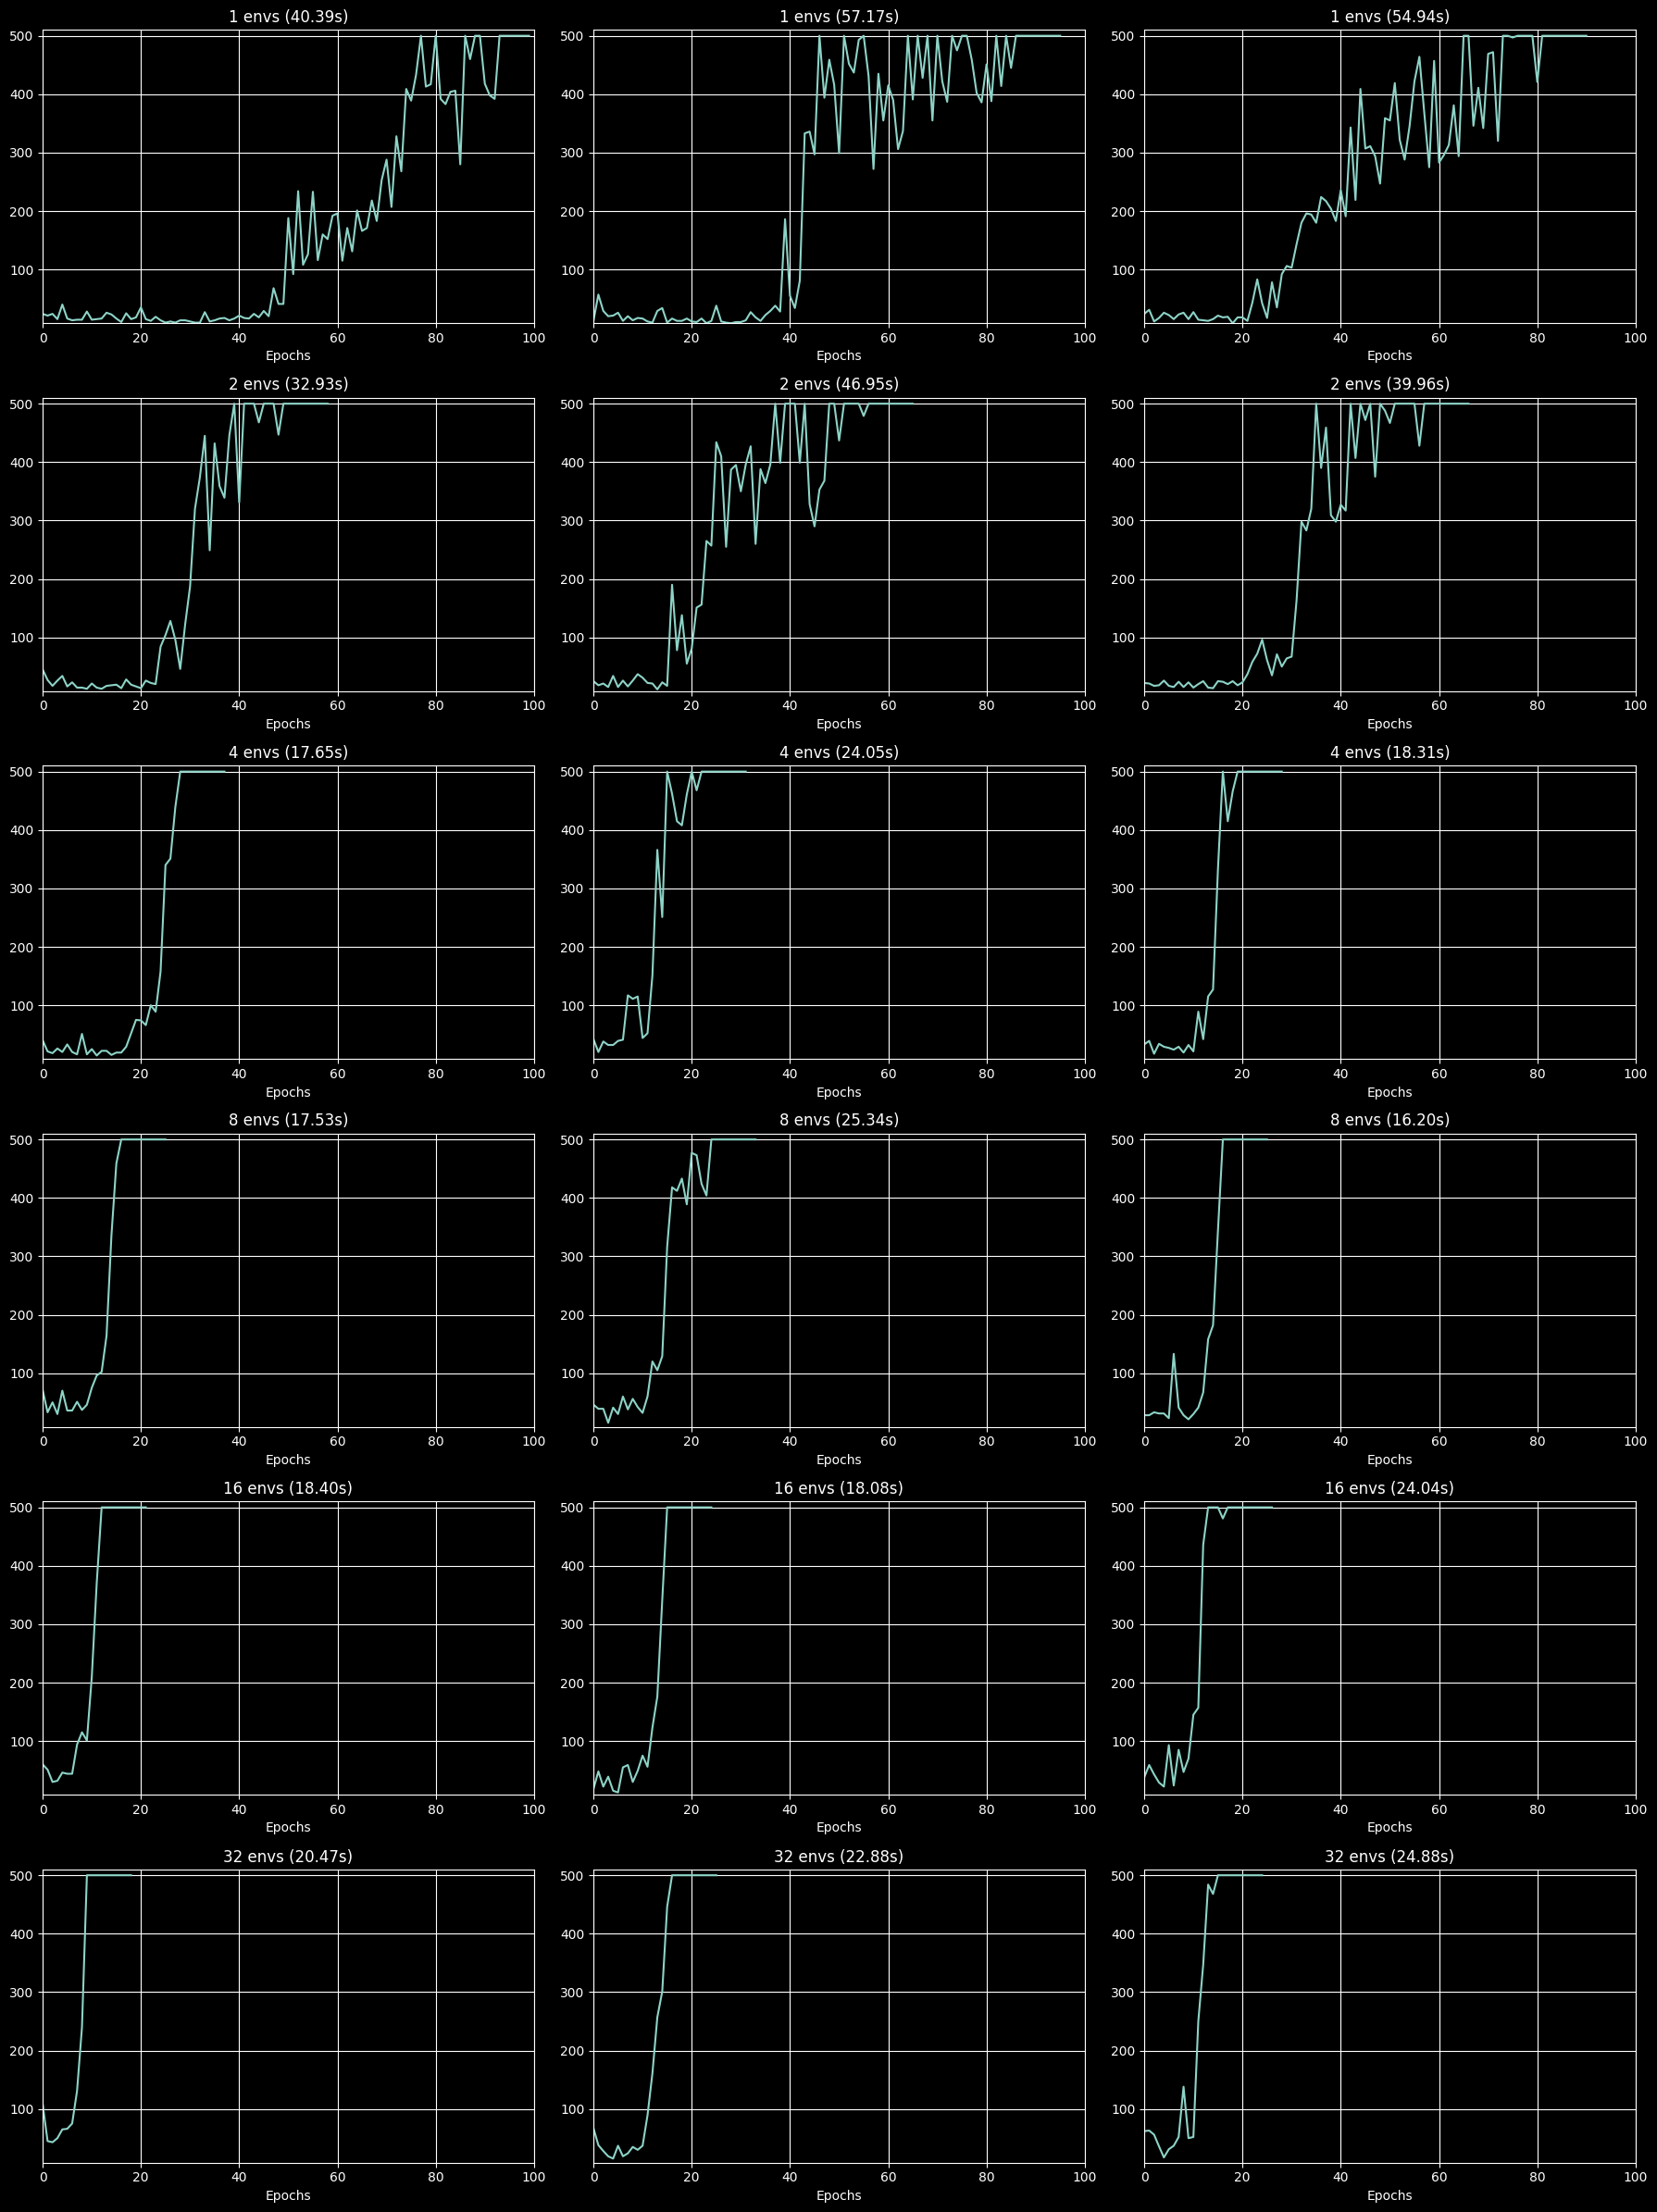

In [24]:
class ReturnableThread(Thread):
    # This class is a subclass of Thread that allows the thread to return a value.
    def __init__(self, target):
        Thread.__init__(self)
        self.target = target
        self.result = None

    def start(self):
        self.start_time = time.clock_gettime(time.CLOCK_THREAD_CPUTIME_ID)
        Thread.start(self)
    
    def run(self) -> None:
        self.result = self.target()
        self.end_time = time.clock_gettime(time.CLOCK_THREAD_CPUTIME_ID)

    def get_time(self):
        return self.end_time - self.start_time

# keep in mind, an 8 core CPU has 16 threads
es = [1, 1, 1, 2, 2, 2, 4, 4, 4, 8, 8, 8, 16, 16, 16, 32, 32, 32]

# # async threading
# allThreads = []
# for e in es:
#     newThread = ReturnableThread(target=lambda: train(e))
#     newThread.start()
#     allThreads.append(newThread)
# for thread in allThreads:
#     while thread.result is None:
#         time.sleep(0.1)
# outputs = [thread.result for thread in allThreads]
# graphs_compare(
#     *outputs,
#     labels=["%s envs (%.2fs)" % (e, thread.get_time()) for e, thread in zip(es, allThreads)]
# )

# synchronous execution
outputs = []
times = []
for e in es:
    start_time = time.time()
    outputs.append(train(e))
    times.append(time.time() - start_time)

graphs_compare(
    *outputs,
    labels=[f"{e} envs ({t:.2f}s)" for e, t in zip(es, times)]
) 

## Conclusion
Shown above, we can conclude that running **16** simulations in parallel yields the most stable and fast results. This can be attributed to the pc's 8 core CPUs and the fact that each core can handle 2 threads. Beyond that, the simulations become a significant bottleneck.

Using 16 asynchronous environments for CartPole-v1, a simple NN, and an optimized frequent reward system, we yield convergence in around 20 episodes. This is a large improvement to the single environment setup that converged in roughly 100 episodes with notable fluctuations.

Note: filling buffer with random-action states before training showed significant decreases in performance.

In [12]:
#train(4, 128, display_live=True)
#
#print('Complete')
#plot_durations(show_result=True)
#plt.ioff()
#plt.show()